In [141]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
from scipy.spatial.distance import pdist
from umap import UMAP
from sklearn.decomposition import PCA
from rdkit.Chem import MolFromSmiles, MolToSmiles
import numpy as np
import os
import sys
from pathlib import Path

# Max rows in pandas unlimited
pd.set_option('display.max_rows', None)

script_dir = Path(os.path.abspath(""))
base_dir = Path(*script_dir.parts[:-1])
sys.path.append( str(base_dir / 'src/') )
DATASET_DIR = base_dir / 'datasets'
FONT_DIR = base_dir / 'fonts'

font_files = font_manager.findSystemFonts(fontpaths=str(FONT_DIR))

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'DM Sans 24pt'

In [121]:
mean_df = pd.read_csv(DATASET_DIR / "mixtures/mixture_rdkit_mean_definitions_clean.csv")
pna_df = pd.read_csv(DATASET_DIR / "mixtures/mixture_rdkit_definitions_clean.csv")
mix_df = pd.read_csv(DATASET_DIR / "mixtures/mixtures_combined.csv")
smi_df = pd.read_csv(DATASET_DIR / "mixtures/mixture_smi_definitions_clean.csv")
smi_df['length'] = smi_df.apply(lambda row: len(row[2:].dropna()), axis=1)

In [122]:
self_df = mix_df[mix_df['Mixture 1'] == mix_df['Mixture 2']]
self_df = pd.merge(self_df[['Dataset', 'Mixture 1', 'Experimental Values']], smi_df[['Dataset', 'Mixture Label', 'length']], left_on=['Dataset', 'Mixture 1'], right_on=['Dataset', 'Mixture Label'])

Text(37.847222222222214, 0.5, 'Number of Components')

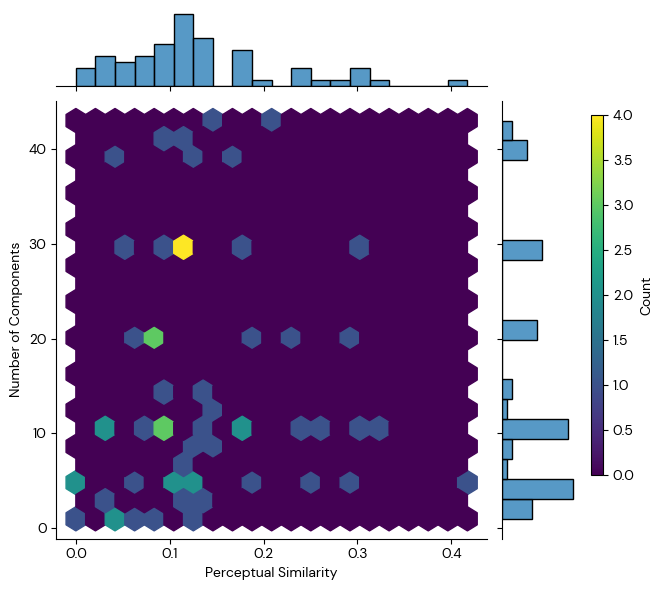

In [123]:
#fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)
#g = sns.scatterplot(x='Experimental Values', y='length', data=self_df, ax=ax)
# Reduce bin size of joint plot
g = sns.jointplot(x='Experimental Values', y='length',  kind='hex', data=self_df, gridsize=20, marginal_kws=dict(bins=20), cmap='viridis')
cax = g.figure.add_axes([1.0, 0.2, 0.02, 0.6])
cbar = g.figure.colorbar(g.ax_joint.collections[0], cax=cax)
cbar.set_label("Count")

g.ax_joint.set_xlabel('Perceptual Similarity', fontname='DM Sans 24pt')
g.ax_joint.set_ylabel('Number of Components', fontname='DM Sans 24pt')

Text(0, 0.5, 'Counts')

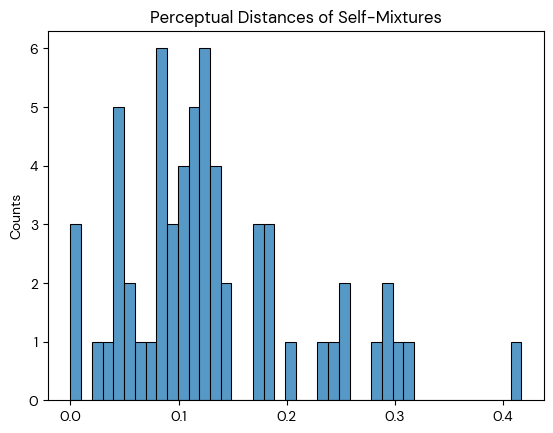

In [124]:
g = sns.histplot(mix_df[mix_df['Mixture 1'] == mix_df['Mixture 2']]['Experimental Values'].values, binwidth=0.01)
g.set_title("Perceptual Distances of Self-Mixtures")
g.set_ylabel('Counts', fontname='DM Sans 24pt')

# Figure 2

In [125]:
def get_umap(df, metric="cosine", title_name=""):
    umap_model = UMAP(metric = metric, densmap=True, random_state=42, low_memory = False)
    X_umap = umap_model.fit_transform(list(df[df.columns[3:]].values))
    df["UMAP_0"], df["UMAP_1"] = X_umap[:,0], X_umap[:,1]
    fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)
    g = sns.scatterplot(x="UMAP_0", y="UMAP_1", data=df, hue='length', palette='viridis', ax=ax, s=12, alpha=0.5)
    norm = plt.Normalize(df['length'].min(), df['length'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Number of Components")
    ax.set_title(title_name)
    ax.get_legend().remove()
    return df

def get_pca(df, title_name=""):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(list(df[df.columns[3:]].values))
    df["PCA_0"], df["PCA_1"] = X_pca[:,0], X_pca[:,1]
    fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)
    g = sns.scatterplot(x="PCA_0", y="PCA_1", data=df, ax=ax, hue='length', palette='viridis', s=12, alpha=0.5)
    norm = plt.Normalize(df['length'].min(), df['length'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Number of Components")
    ax.set_xlabel(f"PC0 ({pca.explained_variance_ratio_[0]*100:.01f}%)")
    ax.set_ylabel(f"PC1 ({pca.explained_variance_ratio_[1]*100:.01f}%)")
    ax.set_title(title_name)
    ax.get_legend().remove()
    return df



In [201]:
plot_pna_df = pd.merge(smi_df[['Dataset', 'Mixture Label', 'length']], pna_df, on=["Dataset", "Mixture Label"], how='left')
plot_pna_df['Master Dataset'] = plot_pna_df['Dataset'].apply(lambda x: x.split(" ")[0])
umap_model = UMAP(metric = 'cosine', densmap=True, random_state=42, low_memory = False)
X_umap = umap_model.fit_transform(list(plot_pna_df[pna_df.columns[3:]].values))
plot_pna_df["UMAP_0"], plot_pna_df["UMAP_1"] = X_umap[:,0], X_umap[:,1]

/u/ctser/.conda/envs/ml/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [241]:
# In smi_df, check if each row is unique compared to other rows based on values from columns 2 onwards  
set_list = {}
for i, row in smi_df.iterrows():
    curr_set = frozenset(row[2:].dropna())
    if curr_set in set_list.keys():
        print(f"Duplicate row found between {set_list[curr_set]} and [{row['Dataset']}, {row['Mixture Label']}]")
        #overlap_df = mix_df[(mix_df['Dataset'] == set_list[curr_set][0]) & (mix_df['Mixture 1'] == set_list[curr_set][1]) & (mix_df['Mixture 2'] == row['Mixture Label'])]
        #print(overlap_df)
    else:
        set_list[curr_set] = [row['Dataset'], row['Mixture Label']]

Duplicate row found between ['Ravia 4', 11] and [Ravia 4, 35]
Duplicate row found between ['Ravia 4', 13] and [Ravia 4, 40]
Duplicate row found between ['Ravia 4', 46] and [Ravia 4, 52]
Duplicate row found between ['Ravia 4', 42] and [Ravia 4, 56]
Duplicate row found between ['Ravia 4', 89] and [Ravia 4, 92]
Duplicate row found between ['Ravia 4', 82] and [Ravia 4, 99]
Duplicate row found between ['Bushdid', 159] and [Bushdid, 317]
Duplicate row found between ['Snitz 1', 3] and [Snitz 3, 2]
Duplicate row found between ['Snitz 1', 32] and [Snitz 3, 3]
Duplicate row found between ['Snitz 1', 45] and [Snitz 3, 8]
Duplicate row found between ['Snitz 1', 20] and [Snitz 3, 20]
Duplicate row found between ['Snitz 1', 15] and [Snitz 3, 21]
Duplicate row found between ['Snitz 1', 27] and [Snitz 3, 48]
Duplicate row found between ['Snitz 2', 5] and [Ravia 1, 2]
Duplicate row found between ['Snitz 2', 8] and [Ravia 1, 4]
Duplicate row found between ['Snitz 2', 12] and [Ravia 1, 6]
Duplicate row f

In [238]:
len(set_list.keys())

763

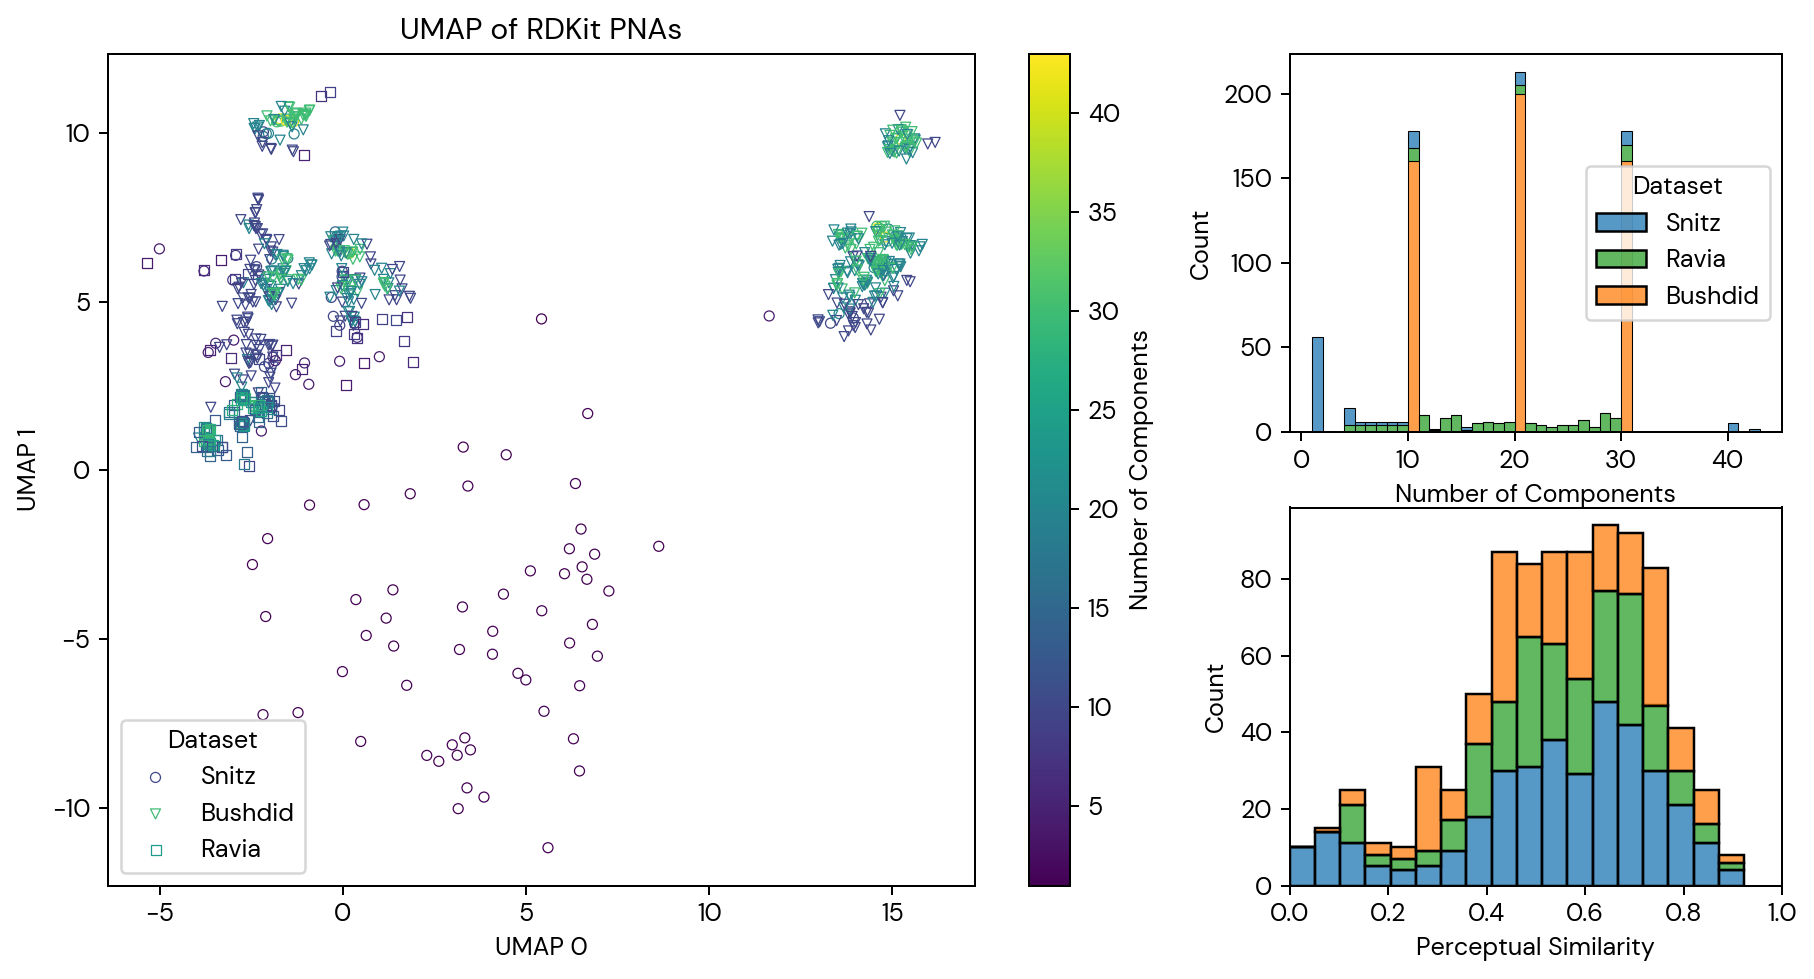

In [270]:
fig = plt.figure(figsize=(12, 6), dpi=180)
gs = fig.add_gridspec(2, 3)
ax = []
ax.append( fig.add_subplot(gs[:,0:2]) ) 
ax.append( fig.add_subplot(gs[0,2]) )
ax.append( fig.add_subplot(gs[1,2]) )

# UMAP
markers = {"Snitz": 'o', 'Bushdid': 'v', 'Ravia': 's'}
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(plot_pna_df['length'].min(), plot_pna_df['length'].max())

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plot_pna_df['edge_color'] = plot_pna_df.apply(lambda row: sm.to_rgba(row['length']), axis=1)

for dataset, marker in markers.items():
    subset = plot_pna_df[plot_pna_df["Master Dataset"] == dataset]
    ax[0].scatter(subset["UMAP_0"], subset["UMAP_1"], 
                  facecolors='none', edgecolors=subset["edge_color"], 
                  marker=marker, s=16, linewidth=0.5, label=dataset)

cbar = fig.colorbar(sm, ax=ax[0])
cbar.set_label("Number of Components")
ax[0].set_title("UMAP of RDKit PNAs")
ax[0].legend(title='Dataset')
ax[0].set_xlabel("UMAP 0")
ax[0].set_ylabel("UMAP 1")

# Components histogram 

dataset_colors = {"Snitz": 'tab:blue', 'Bushdid': 'tab:orange', 'Ravia': 'tab:green'}

if False:
    counts, bin_edges = np.histogram(smi_df['length'], bins=max(smi_df['length']))

    for i in range(len(bin_edges) - 1):
        color = cmap(norm((bin_edges[i] + bin_edges[i + 1]) / 2))
        ax[1].bar(bin_edges[i], counts[i], color=color, width=bin_edges[i + 1] - bin_edges[i])
else:
    plot_smi_df = smi_df.copy()
    plot_smi_df['Dataset'] = plot_smi_df['Dataset'].apply(lambda x: x.split(" ")[0])
    g1 = sns.histplot(plot_smi_df, x='length', hue='Dataset', palette=dataset_colors, multiple='stack', ax=ax[1], binwidth=1)   

ax[1].set_xlabel("Number of Components")
ax[1].set_ylabel("Count")
#ax[1].set_yscale('log')

# Label distribution by dataset
plot_mix_df = mix_df.copy()
plot_mix_df['Dataset'] = plot_mix_df['Dataset'].apply(lambda x: x.split(" ")[0])
g2 = sns.histplot(plot_mix_df, x='Experimental Values', hue='Dataset', palette=dataset_colors, multiple='stack', ax=ax[2])

#ax[2].set_yscale('log')
ax[2].set_xlim([0, 1])
ax[2].set_xlabel("Perceptual Similarity")
ax[2].get_legend().remove()


In [24]:
mix_df["Mean Cosine Distance"] = mix_df.apply(lambda row: get_distance(row["Dataset"], row["Mixture 1"], row["Mixture 2"], mean_df), axis=1)
mix_df["PNA Cosine Distance"] = mix_df.apply(lambda row: get_distance(row["Dataset"], row["Mixture 1"], row["Mixture 2"], pna_df), axis=1)

Text(0, 0.5, 'Perceptual Similarity')

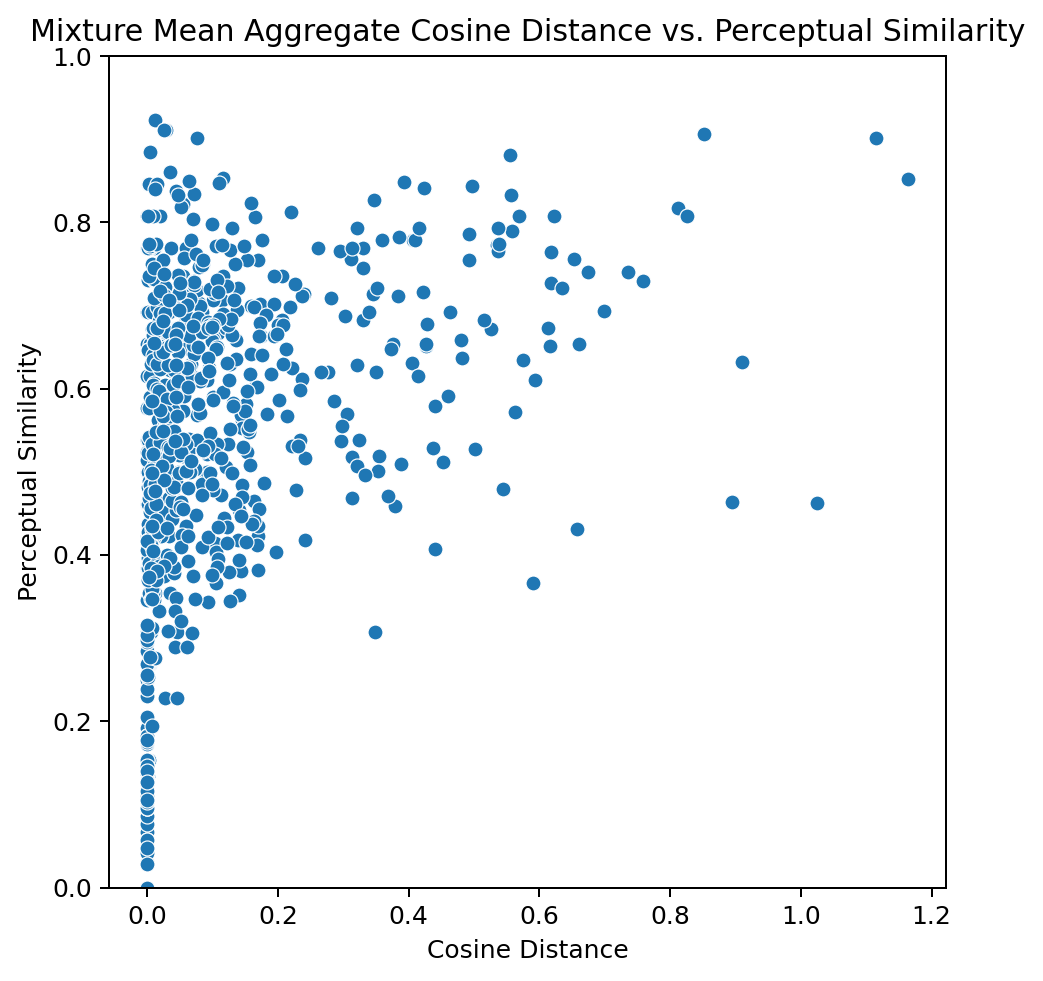

In [25]:
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)

g = sns.scatterplot(x="Mean Cosine Distance", y='Experimental Values', data=mix_df, ax=ax)

ax.set_ylim([0, 1])
ax.set_title("Mixture Mean Aggregate Cosine Distance vs. Perceptual Similarity")
ax.set_xlabel("Cosine Distance")
ax.set_ylabel("Perceptual Similarity")

Text(0, 0.5, 'Perceptual Similarity')

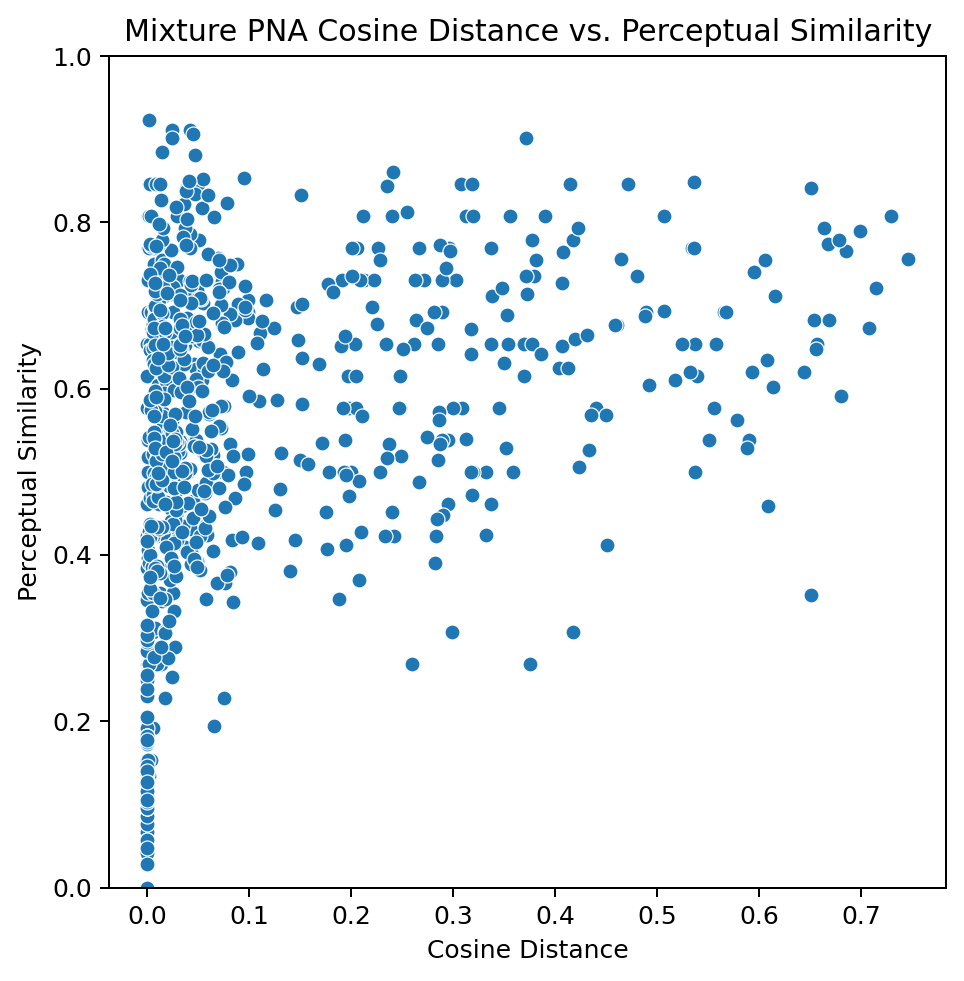

In [26]:
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)

g = sns.scatterplot(x="PNA Cosine Distance", y='Experimental Values', data=mix_df, ax=ax)

ax.set_ylim([0, 1])
ax.set_title("Mixture PNA Cosine Distance vs. Perceptual Similarity")
ax.set_xlabel("Cosine Distance")
ax.set_ylabel("Perceptual Similarity")